This script is used for random testing and analysis for which I don't want to create a unique script, but want to have a way to reference my process if I have to end a session or get disconnected.

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import math
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# paths to various directories
rda_era5_path = '/glade/campaign/collections/rda/data/ds633.0/'  # base path to ERA5 data on derecho
my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions

# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data, time_to_year_month_avg, time_to_year_month_sum, time_to_year_month
from my_functions import month_num_to_name, ensure_var_list

# import lists and dictionaries
from my_dictionaries import (
sfc_instan_list, sfc_accumu_list, pl_var_list, derived_var_list, invar_var_list,
NAM_var_list, region_avg_list, flux_var_list, vector_var_list, misc_var_list,
var_dict, var_units, region_avg_dict, region_avg_coords, region_colors_dict
)

In [2]:
def plot_2d_data(cf_da=None, cs_da=None, geopolitical_borders=True, **kwargs):
    """
    Plots 2d data over some geographic region.  two xarray DataArrays can be input, one for shaded contours and one for lined contours.

    Parameters
    ----------
    cf_da: xarray.DataArray, optional
        A data array to be plotted with shaded contours
    cs_da: xarray DataArray, optional
        A data array to be plotted with lined contours
    geopolitical_borders: bool, optional, default: True
        Whether to plot state/coastline boundaries

    Keyword Arguments
    -----------------
    vmin: int or float, optional, default: da.min()
        The minimum value of shaded contours
    vmax: int or float, optional, default: da.max()
        The maximum value of shaded contours
    projection: cartopy feature, optional, default: ccrs.PlateCarree()
        The projection to be used
    transform: cartopy feature, optional, default: ccrs.PlateCarree()
        The transform to be used. Should match projection in most cases
    cmap: str, optional, default: 'turbo'
        The colormap option to use in the matplotlib library
    cs_levels: int or array of int, optional, default: 20
        The number of levels or an array specifying the levels to be used in lined contours
    linewidths: float or int, optional, default: 0.5
        Width of lined contours
    linestyles: str, optional, default: '--'
        Line style of lined contours
    colors: str, optional, default: 'black'
        Color of lined contours
    cbar_label: str, optional, default: 'CBAR_LABEL'
        The label for the colorbar
    fig_title: str, optional, default: "FIGURE TITLE'
        The title of the figure
    save_png: bool, optional, default: False
        Whether to save the figure. If True, out_fp must be specified.
    out_fp: str, optional
        Where to save the figure if save_png is True.

    Returns
    -------
    matplotlib Figure
    """
    if cf_da is None and cs_da in None:
        raise ValueError("Either cf_da or cs_da must not be None")

    vmin = kwargs.get('vmin', cf_da.min().compute().values)
    vmax = kwargs.get('vmax', cf_da.max().compute().values)
    cf_levels = np.linspace(vmin, vmax, 100)
    norm = plt.Normalize(vmin, vmax)
    
    projection = kwargs.get('projection', ccrs.PlateCarree())
    transform = kwargs.get('transform', ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=projection))

    if cf_da is not None:
        cf = ax.contourf(cf_da.longitude, cf_da.latitude, cf_da, levels=cf_levels,
                         cmap=kwargs.get('cmap', 'turbo'), norm=norm, extend='both', transform=transform)
    if cs_da is not None:
        cs = ax.contour(cs_da.longitude, cs_da.latitude, cs_da, levels=kwargs.get('cs_levels', 20),
                        linewidths=kwargs.get('linewidths', 0.5), linestyles=kwargs.get('linestyles', '--'),
                        colors=kwargs.get('colors', 'black'), transform=transform)

    if geopolitical_borders:
        # add coastlines, state borders, and other features
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

    # add colorbar, contours, and title
    if cf_da is not None:
        plt.colorbar(cf, ax=ax, label=kwargs.get('cbar_label', 'CBAR_LABEL'), pad=0.02)
    if cs_da is not None:
        plt.clabel(cs, inline=True, fontsize=8, fmt='%1.1f')
    fig.suptitle(kwargs.get('fig_title', 'FIGURE TITLE'))
    plt.tight_layout()
    if kwargs.get('save_png', False):
        out_fp = kwargs.get('out_fp', None)
        base_path = '/'.join(out_fp.split('/')[:-1])
        if not out_fp:
            raise ValueError("out_fp must be specified if saving plot")
        if not os.path.exists(base_path):
            raise FileNotFoundError(f"{base_path} is not a valid filepath")
        else:
            plt.savefig(out_fp, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

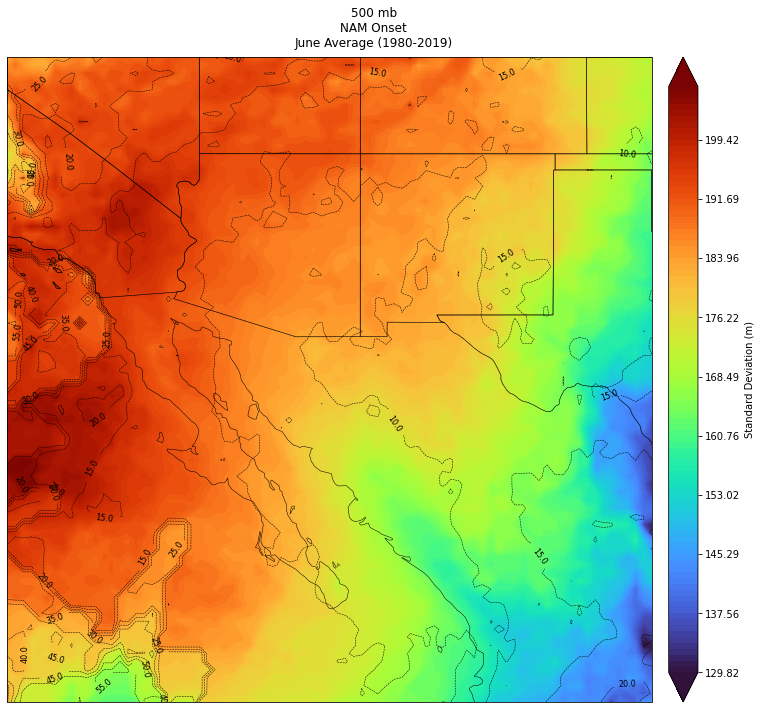

In [7]:
# plot precip data to see where NAM core is
var = 'onset'
var_level = 500

data = get_var_data(var, level=500)
data_cf = data.mean('year', skipna=True)
data_cs = data.std('year', skipna=True)

main_kwargs = {
    'vmin': data_cf.min().compute().values,
    'vmax': data_cf.max().compute().values,
    'cmap': 'turbo',
    'cs_levels': 10,
    'cbar_label': 'Standard Deviation (m)',
    'fig_title': f'500 mb\n{var_dict[var]}\nJune Average (1980-2019)',
    'out_fp': f'{plot_out_path}spatial/dsw/z_height_500_mean_1980-2019_dsw.png',
    'save_png': False,
}   

try:
    kwargs = main_kwargs.copy()
    if var in pl_var_list:
        kwargs.update({'level': var_level})
    plot_2d_data(data_cf, data_cs, **kwargs)
except Exception as e:
    print(e)